In [0]:
iteration = 100
batchsize = 16
snapshot_interval = 20
display_interval = 20
update_interval = 20
phase = 0
'''
0- : all decoder training.
1- : trans encoding.
2- : adversarial encording.
'''

'\n0- : all decoder training.\n1- : trans encoding.\n2- : adversarial encording.\n'

In [0]:
mount = '/content/gdrive'

from google.colab import drive
drive.mount(mount)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy
import math
import glob
from PIL import Image, ImageOps, ImageChops, ImageFilter
import matplotlib.pyplot as plt
import cupy

import chainer
from chainer import training, backend, Variable
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
import chainer.backends.cuda

from IPython.display import clear_output

In [0]:
def gaussian(size):
    return F.gaussian(cupy.zeros(size, dtype=cupy.float32),
                     cupy.ones(size, dtype=cupy.float32))

In [0]:
def make_optimizer_Adam(model, alpha=1e-4, beta1=0.9, clip=True):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    if clip:
        optimizer.add_hook(chainer.optimizer_hooks.GradientClipping(1.))
    return optimizer

In [0]:
def out_generated_image(gen, c_iter, v_iter):
    @chainer.training.make_extension()
    def make_image(trainer):
        clear_output()
        xp = gen.xp
        c_base = xp.asarray(c_iter.next())
        z_c = Variable(c_base[:,1])/255. *2. -1.
        if phase < 7:
            v_base = c_base[:,0]
        else:
            v_base = xp.asarray(v_iter.next())[:,0]
        z_v = Variable(v_base)/255. *2. -1.
        
        with chainer.using_config('train', False):
            x = gen(z_c, z_v)
        x = F.transpose(F.reshape(x, (-1, 3, 128, 128)), (0, 2, 3, 1))
        x = chainer.backends.cuda.to_cpu(x.array)
        
        plt.figure(figsize=(16, 12))
        
        
        for i, img in enumerate(xp.asnumpy(c_base[:,1])):
            plt.subplot(3,4,i+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(numpy.uint8(img).transpose((1, 2, 0))))
            
        for i, img in enumerate(x):
            plt.subplot(3,4,i+5)
            plt.axis('off')
            plt.imshow(Image.fromarray(numpy.uint8((img+1.)/2. *255.)))
            
        for i, img in enumerate(xp.asnumpy(v_base)):
            plt.subplot(3,4,i+9)
            plt.axis('off')
            plt.imshow(Image.fromarray(numpy.uint8(img).transpose((1, 2, 0))))
        
        plt.show()
    return make_image

In [0]:
class Encoder(chainer.Chain):

    def __init__(self, wscale=1.):
        super(Encoder, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.c0_0 = L.Convolution2D(3, 64, 1, 1, 0, initialW=w)
            self.bn0_0 = L.BatchNormalization(64)
            self.c0_1 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.bn0_1 = L.BatchNormalization(64)
            
            self.c1_0 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.bn1_0 = L.BatchNormalization(128)
            self.c1_1 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.bn1_1 = L.BatchNormalization(128)
            self.c1_2 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.bn1_2 = L.BatchNormalization(128)
            self.c1_3 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.bn1_3 = L.BatchNormalization(128)
            
            self.c2_0 = L.Convolution2D(None, 256, 3, 1, 1, initialW=w)
            self.bn2_0 = L.BatchNormalization(256)
            self.c2_1 = L.Convolution2D(None, 256, 1, 1, 0, initialW=w)
            self.bn2_1 = L.BatchNormalization(256)
            self.c2_2 = L.Convolution2D(None, 256, 1, 1, 0, initialW=w)
            self.bn2_2 = L.BatchNormalization(256)
            self.c2_3 = L.Convolution2D(None, 256, 1, 1, 0, initialW=w)
            self.bn2_3 = L.BatchNormalization(256)
            
            self.c3_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn3_0 = L.BatchNormalization(512)
            self.c3_1 = L.Convolution2D(None, 512, 1, 1, 0, initialW=w)
            self.bn3_1 = L.BatchNormalization(512)
            self.c3_2 = L.Convolution2D(None, 512, 1, 1, 0, initialW=w)
            self.bn3_2 = L.BatchNormalization(512)
            self.c3_3 = L.Convolution2D(None, 512, 1, 1, 0, initialW=w)
            self.bn3_3 = L.BatchNormalization(512)
            
            self.c4_0 = L.Convolution2D(None, 1024, 3, 1, 1, initialW=w)
            self.bn4_0 = L.BatchNormalization(1024)
            self.c4_1 = L.Convolution2D(None, 1024, 1, 1, 0, initialW=w)
            self.bn4_1 = L.BatchNormalization(1024)
            self.c4_2 = L.Convolution2D(None, 1024, 1, 1, 0, initialW=w)
            self.bn4_2 = L.BatchNormalization(1024)
            self.c4_3 = L.Convolution2D(None, 1024, 1, 1, 0, initialW=w)
            self.bn4_3 = L.BatchNormalization(1024)
            
            self.l1 = L.Linear(None, 1024, initialW=w)
            self.l2 = L.Linear(None, 1024, initialW=w)
            self.l_out = L.Linear(None, 1024, initialW=w)
    
    def self_attention(self, x, f, g, h, gamma=0.01):
        f_shape = f.shape
        g_shape = g.shape
        h_shape = h.shape
        
        attention_map = F.batch_matmul(F.reshape(f, (-1, f_shape[2], f_shape[3])),
                                       F.reshape(g, (-1, g_shape[2], g_shape[3])),
                                       transb=True)
        feature_map = F.batch_matmul(F.reshape(h, (-1, h_shape[2], h_shape[3])),
                                     attention_map, transb=True)
        feature_map = F.reshape(feature_map, h_shape)
        return F.add(x, feature_map*gamma)
    
    def gap(self, x):
        return F.average_pooling_2d(x, x.shape[3])
    
    def forward(self, z):
        batch = z.shape[0]
        x = F.relu(self.bn0_0(self.c0_0(z)))
        x = F.relu(self.bn0_1(self.c0_1(x)))
        # 128
        x = F.max_pooling_2d(x, 2)
        x = F.relu(self.bn1_0(self.c1_0(x)))
        f = F.tanh(self.bn1_1(self.c1_1(x)))
        g = F.tanh(self.bn1_2(self.c1_2(x)))
        h = F.tanh(self.bn1_3(self.c1_3(x)))
        x = F.relu(self.self_attention(x, f, g, h))
        # 64
        x = F.max_pooling_2d(x, 2)
        x = F.relu(self.bn2_0(self.c2_0(x)))
        f = F.tanh(self.bn2_1(self.c2_1(x)))
        g = F.tanh(self.bn2_2(self.c2_2(x)))
        h = F.tanh(self.bn2_3(self.c2_3(x)))
        x = F.relu(self.self_attention(x, f, g, h))
        # 32
        x = F.max_pooling_2d(x, 2)
        x = F.relu(self.bn3_0(self.c3_0(x)))
        f = F.tanh(self.bn3_1(self.c3_1(x)))
        g = F.tanh(self.bn3_2(self.c3_2(x)))
        h = F.tanh(self.bn3_3(self.c3_3(x)))
        x = F.relu(self.self_attention(x, f, g, h))
        # 16
        x = F.max_pooling_2d(x, 2)
        x = F.relu(self.bn4_0(self.c4_0(x)))
        f = F.tanh(self.bn4_1(self.c4_1(x)))
        g = F.tanh(self.bn4_2(self.c4_2(x)))
        h = F.tanh(self.bn4_3(self.c4_3(x)))
        x = F.relu(self.self_attention(x, f, g, h))
        # 8
        x = self.gap(x)
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l_out(x))
        return x

In [0]:
class DiscriminatorGen(chainer.Chain):

    def __init__(self, wscale=1.):
        super(DiscriminatorGen, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.c0 = L.Convolution2D(3, 64, 3, 1, 1, initialW=w)
            self.bn0 = L.BatchNormalization(64)
            
            self.c1 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.bn1 = L.BatchNormalization(64)
            
            self.c2_0 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.bn2_0 = L.BatchNormalization(128)
            self.c2_1 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.bn2_1 = L.BatchNormalization(128)
            
            self.c3_0 = L.Convolution2D(None, 256, 3, 1, 1, initialW=w)
            self.bn3_0 = L.BatchNormalization(256)
            self.c3_1 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.bn3_1 = L.BatchNormalization(128)
            
            self.c4_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn4_0 = L.BatchNormalization(512)
            self.c4_1 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.bn4_1 = L.BatchNormalization(128)
            
            self.c5_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn5_0 = L.BatchNormalization(512)
            self.c5_1 = L.Convolution2D(None, 256, 3, 1, 1, initialW=w)
            self.bn5_1= L.BatchNormalization(256)
            
            self.c6_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn6_0 = L.BatchNormalization(512)
            self.c6_1 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn6_1 = L.BatchNormalization(512)
            
            self.cb = L.Convolution2D(None, 512, 1, 1, 0, initialW=w)
            self.bnb = L.BatchNormalization(512)
            
            self.c7 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn7 = L.BatchNormalization(512)
            
            self.c8 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn8 = L.BatchNormalization(512)
            
            self.c9 = L.Convolution2D(None, 32, 3, 1, 1, initialW=w)
            self.bn9 = L.BatchNormalization(32)
            
            self.l_m = L.Linear(None, 1024, initialW=w)
            self.t = L.Linear(None, 64*16, initialW=None)
            
            self.l_o = L.Linear(None, 1, initialW=w)

    def minibatch_discrimination(self, m):
        batchsize = m.shape[0]
        m = F.expand_dims(m, 3)
        m_T = F.transpose(m, (3, 1, 2, 0))
        m, m_T = F.broadcast(m, m_T)
        norm = F.sum(F.absolute_error(m, m_T), axis=2)
        eraser = F.broadcast_to(cupy.eye(batchsize, dtype=cupy.float32).reshape((batchsize, 1, batchsize)), norm.shape)
        c_b = F.exp(-(norm + 1e6 * eraser))
        o_b = F.sum(c_b, axis=2)
        return o_b
        
    def gaussian(self, x):
        return F.gaussian(x, cupy.ones(x.shape, dtype=cupy.float32)*1e-1)
    
    def forward(self, z):
        batchsize = z.shape[0]
        h = F.leaky_relu(self.bn0(self.c0(self.gaussian(z))))
        h = F.leaky_relu(self.bn1(self.c1(self.gaussian(h))))
        # 128
        h = F.space2depth(h, 2)
        h = F.leaky_relu(self.bn2_0(self.c2_0(self.gaussian(h))))
        h = F.leaky_relu(self.bn2_1(self.c2_1(self.gaussian(h))))
        # 64
        h = F.space2depth(h, 2)
        h = F.leaky_relu(self.bn3_0(self.c3_0(self.gaussian(h))))
        h = F.leaky_relu(self.bn3_1(self.c3_1(self.gaussian(h))))
        # 32
        h = F.space2depth(h, 2)
        h = F.leaky_relu(self.bn4_0(self.c4_0(self.gaussian(h))))
        h = F.leaky_relu(self.bn4_1(self.c4_1(self.gaussian(h))))
        h_16 = h
        # 16
        h = F.space2depth(h, 2)
        h = F.leaky_relu(self.bn5_0(self.c5_0(self.gaussian(h))))
        h = F.leaky_relu(self.bn5_1(self.c5_1(self.gaussian(h))))
        h_8 = h
        # 8
        h = F.space2depth(h, 2)
        h = F.leaky_relu(self.bn6_0(self.c6_0(self.gaussian(h))))
        h = F.leaky_relu(self.bn6_1(self.c6_1(self.gaussian(h))))
        h_4 = h
        # 4
        h = F.space2depth(h, 2)
        h = F.leaky_relu(self.bnb(self.cb(self.gaussian(h))))
        # 2
        
        h = F.depth2space(h, 2)
        h = F.concat((h, h_4))
        h = F.leaky_relu(self.bn7(self.c7(h)))
        # 4
        
        h = F.depth2space(h, 2)
        h = F.concat((h, h_8))
        h = F.leaky_relu(self.bn8(self.c8(h)))
        # 8
        
        h = F.depth2space(h, 2)
        h = F.concat((h, h_16))
        h = F.leaky_relu(self.bn9(self.c9(h)))
        # 16
        
        h_m = F.leaky_relu(self.l_m(h))
        m = F.reshape(self.t(h_m), (batchsize, 64, 16))
        o_b = self.minibatch_discrimination(m)
        
        h = F.concat((h_m, o_b), axis=1)
        
        return self.l_o(h), h_m

In [0]:
class DiscriminatorEn(chainer.Chain):

    def __init__(self, wscale=1.):
        super(DiscriminatorEn, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.l0 = L.Linear(None, 1024, initialW=w)
            self.l1 = L.Linear(None, 1024, initialW=w)
            self.t = L.Linear(None, 64*16, initialW=None)
            
            self.l_o = L.Linear(None, 1, initialW=w)

    def minibatch_discrimination(self, m):
        batchsize = m.shape[0]
        m = F.expand_dims(m, 3)
        m_T = F.transpose(m, (3, 1, 2, 0))
        m, m_T = F.broadcast(m, m_T)
        norm = F.sum(F.absolute_error(m, m_T), axis=2)
        eraser = F.broadcast_to(cupy.eye(batchsize, dtype=cupy.float32).reshape((batchsize, 1, batchsize)), norm.shape)
        c_b = F.exp(-(norm + 1e6 * eraser))
        o_b = F.sum(c_b, axis=2)
        return o_b
        
    def forward(self, z):
        batchsize = z.shape[0]
        h = F.relu(self.l0(z))
        h = F.relu(self.l1(h))
        m = F.reshape(self.t(h), (batchsize, 64, 16))
        o_b = self.minibatch_discrimination(m)
        
        out = F.concat((h, o_b), axis=1)
        
        return self.l_o(out)

In [0]:
class Decoder(chainer.Chain):

    def __init__(self, wscale=1.):
        super(Decoder, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.lsg_64 = L.Linear(None, 64*64, initialW=w)
            self.lsb_64 = L.Linear(None, 64, initialW=w)
            self.lsg_32 = L.Linear(None, 64*64, initialW=w)
            self.lsb_32 = L.Linear(None, 64, initialW=w)
            self.lsg_16 = L.Linear(None, 64*64, initialW=w)
            self.lsb_16 = L.Linear(None, 64, initialW=w)
            
            self.enc0_0 = L.Convolution2D(3, 32, 1, 1, 0, initialW=w)
            self.enbnc0_0 = L.BatchNormalization(32)
            self.enc0_1 = L.Convolution2D(None, 32, 3, 1, 1, initialW=w)
            self.enbnc0_1 = L.BatchNormalization(32)
            
            self.enc1_0 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.enbnc1_0 = L.BatchNormalization(32)
            self.enc1_1 = L.Convolution2D(None, 32, 3, 1, 1, initialW=w)
            self.enbnc1_1 = L.BatchNormalization(32)
            self.enc1_2 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.enbnc1_2 = L.BatchNormalization(32)
            self.enc1_3 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.enbnc1_3 = L.BatchNormalization(32)
            self.enc1_4 = L.Convolution2D(None, 64, 1, 1, 0, initialW=w)
            self.enbnc1_4 = L.BatchNormalization(64)
            
            self.enc2_0 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.enbnc2_0 = L.BatchNormalization(32)
            self.enc2_1 = L.Convolution2D(None, 32, 3, 1, 1, initialW=w)
            self.enbnc2_1 = L.BatchNormalization(32)
            self.enc2_2 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.enbnc2_2 = L.BatchNormalization(32)
            self.enc2_3 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.enbnc2_3 = L.BatchNormalization(32)
            self.enc2_4 = L.Convolution2D(None, 64, 1, 1, 0, initialW=w)
            self.enbnc2_4 = L.BatchNormalization(64)
            
            self.enc3_0 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.enbnc3_0 = L.BatchNormalization(32)
            self.enc3_1 = L.Convolution2D(None, 32, 3, 1, 1, initialW=w)
            self.enbnc3_1 = L.BatchNormalization(32)
            self.enc3_2 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.enbnc3_2 = L.BatchNormalization(32)
            self.enc3_3 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.enbnc3_3 = L.BatchNormalization(32)
            self.enc3_4 = L.Convolution2D(None, 64, 1, 1, 0, initialW=w)
            self.enbnc3_4 = L.BatchNormalization(64)
            
            self.de4_dc5 = L.Deconvolution2D(None, 256, 5, 1, 2, initialW=w)
            self.debn4_dc5 = L.BatchNormalization(256)
            self.de4_c3 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.debn4_c3 = L.BatchNormalization(128)
            self.de4_c1 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.debn4_c1 = L.BatchNormalization(128)
            
            self.de3_dc5 = L.Deconvolution2D(None, 128, 5, 1, 2, initialW=w)
            self.debn3_dc5 = L.BatchNormalization(128)
            self.de3_c3 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.debn3_c3 = L.BatchNormalization(64)
            self.de3_c1 = L.Convolution2D(None, 64, 1, 1, 0, initialW=w)
            self.debn3_c1 = L.BatchNormalization(64)
            
            self.de2_dc5 = L.Deconvolution2D(None, 64, 5, 1, 2, initialW=w)
            self.debn2_dc5 = L.BatchNormalization(64)
            self.de2_c3 = L.Convolution2D(None, 32, 3, 1, 1, initialW=w)
            self.debn2_c3 = L.BatchNormalization(32)
            self.de2_c1 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w)
            self.debn2_c1 = L.BatchNormalization(32)
            
            self.de1_dc5 = L.Deconvolution2D(None, 32, 5, 1, 2, initialW=w)
            self.debn1_dc5 = L.BatchNormalization(32)
            self.de1_c3 = L.Convolution2D(None, 16, 3, 1, 1, initialW=w)
            self.debn1_c3 = L.BatchNormalization(16)
            self.de1_c1 = L.Convolution2D(None, 16, 1, 1, 0, initialW=w)
            self.debn1_c1 = L.BatchNormalization(16)
            
            self.c_out = L.Convolution2D(None, 3, 1, 1, 0, initialW=w)
    
    def mul(self, a, b):
        a_shape = a.shape
        b_shape = b.shape
        
        x = F.batch_matmul(F.reshape(a, (-1, a_shape[2], a_shape[3])),
                                       F.reshape(b, (-1, b_shape[2], b_shape[3])),
                                       transb=True)
        return F.reshape(x, a_shape)
    
    def spade(self, feature, gamma, beta):
        x = self.mul(feature, gamma)
        x = F.add(x, beta)
        return x
    
    def style_gamma(self, x, gamma):
        batch, ch, w, h = x.shape
        z = F.reshape(x, (batch, ch, -1))
        _, _, ch = gamma.shape
        z = F.batch_matmul(z, gamma, transa=True)
        z = F.transpose(z, (0, 2, 1))
        return F.reshape(z, (batch, ch, w, h))
    
    def style_trans(self, x, gamma, beta):
        h = self.style_gamma(x, gamma)
        h = F.add(h, beta)
        return h
    
    def gaussian(self, batch, ch, w, h):
        size = batch*ch*w*h
        noise = F.gaussian(cupy.zeros(size, dtype=cupy.float32),
                           cupy.ones(size, dtype=cupy.float32))
        return F.reshape(noise, (batch, ch, w, h))
    
    def forward(self, x, z):        
        batch = x.shape[0]
        
        # Encode
        h = F.relu(self.enbnc0_0(self.enc0_0(x)))
        h = F.relu(self.enbnc0_1(self.enc0_1(x)))
        # 128
        h = F.space2depth(h, 2)
        h = F.relu(self.enbnc1_0(self.enc1_0(h)))
        f = F.relu(self.enbnc1_1(self.enc1_1(h)))
        g = F.tanh(self.enbnc1_2(self.enc1_2(h)))
        b = F.tanh(self.enbnc1_3(self.enc1_3(h)))
        h = F.relu(self.spade(f, g, b))
        
        h_64 = F.tanh(self.enbnc1_4(self.enc1_4(h)))
        sg = F.tanh(self.lsg_64(z))
        sg = F.reshape(sg, (batch, 64, 64))
        sb = F.tanh(self.lsb_64(z))
        sb = F.broadcast_to(F.reshape(sb, (batch, 64, 1, 1)),
                            (batch, 64, 64, 64))
        h_64 = F.relu(self.style_trans(h_64, sg, sb))
        # 64
        h = F.space2depth(h, 2)
        h = F.relu(self.enbnc2_0(self.enc2_0(h)))
        f = F.relu(self.enbnc2_1(self.enc2_1(h)))
        g = F.tanh(self.enbnc2_2(self.enc2_2(h)))
        b = F.tanh(self.enbnc2_3(self.enc2_3(h)))
        h = F.relu(self.spade(f, g, b))
        
        h_32 = F.tanh(self.enbnc2_4(self.enc2_4(h)))
        sg = F.tanh(self.lsg_32(z))
        sg = F.reshape(sg, (batch, 64, 64))
        sb = F.tanh(self.lsb_32(z))
        sb = F.broadcast_to(F.reshape(sb, (batch, 64, 1, 1)),
                            (batch, 64, 32, 32))
        h_32 = F.relu(self.style_trans(h_32, sg, sb))
        # 32
        h = F.space2depth(h, 2)
        h = F.relu(self.enbnc3_0(self.enc3_0(h)))
        f = F.relu(self.enbnc3_1(self.enc3_1(h)))
        g = F.tanh(self.enbnc3_2(self.enc3_2(h)))
        b = F.tanh(self.enbnc3_3(self.enc3_3(h)))
        h = F.relu(self.spade(f, g, b))
        
        h = F.tanh(self.enbnc3_4(self.enc3_4(h)))
        sg = F.tanh(self.lsg_16(z))
        sg = F.reshape(sg, (batch, 64, 64))
        sb = F.tanh(self.lsb_16(z))
        sb = F.broadcast_to(F.reshape(sb, (batch, 64, 1, 1)),
                            (batch, 64, 16, 16))
        h = F.relu(self.style_trans(h, sg, sb))
        # 16
        
        # Decode
        h = F.concat((h, self.gaussian(batch, 1, 16, 16)))
        h_dc5 = F.relu(self.debn4_dc5(self.de4_dc5(h)))
        h_c3 = F.relu(self.debn4_c3(self.de4_c3(h_dc5)))
        h_c1 = F.relu(self.debn4_c1(self.de4_c1(h_c3)))
        h = F.concat((h_dc5, h_c3, h_c1))
        # 16
        h = F.depth2space(h, 2)
        h = F.concat((h, h_32, self.gaussian(batch, 1, 32, 32)))
        h_dc5 = F.relu(self.debn3_dc5(self.de3_dc5(h)))
        h_c3 = F.relu(self.debn3_c3(self.de3_c3(h_dc5)))
        h_c1 = F.relu(self.debn3_c1(self.de3_c1(h_c3)))
        h = F.concat((h_dc5, h_c3, h_c1))
        # 32
        h = F.depth2space(h, 2)
        h = F.concat((h, h_64, self.gaussian(batch, 1, 64, 64)))
        h_dc5 = F.relu(self.debn2_dc5(self.de2_dc5(h)))
        h_c3 = F.relu(self.debn2_c3(self.de2_c3(h_dc5)))
        h_c1 = F.relu(self.debn2_c1(self.de2_c1(h_c3)))
        h = F.concat((h_dc5, h_c3, h_c1))
        # 64
        h = F.depth2space(h, 2)
        h = F.concat((h, self.gaussian(batch, 1, 128, 128)))
        h_dc5 = F.relu(self.debn1_dc5(self.de1_dc5(h)))
        h_c3 = F.relu(self.debn1_c3(self.de1_c3(h_dc5)))
        h_c1 = F.relu(self.debn1_c1(self.de1_c1(h_c3)))
        h = F.concat((h_dc5, h_c3, h_c1))
        
        h = F.tanh(self.c_out(h))
        # 128
        
        return h

In [0]:
class Generator(chainer.Chain):

    def __init__(self, encoder, decoder):
        super(Generator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x_c, x_v):
        batch = x_c.shape[0]
        h_v = self.encoder(x_v)
        return self.decoder(x_c, h_v)

In [0]:
class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, *args, **kwargs):
        self.gen, self.dis_gen, self.dis_en = kwargs.pop('models')
        self.cache_fake = None
        self.cache_dis_gen = None
        self.cache_dis_en = None
        self.k = 5
        super(DCGANUpdater, self).__init__(*args, **kwargs)

    def loss_dis(self, dis, ll, opt):
        loss = sum(ll)
        chainer.report({opt: loss}, dis)
        return loss
    
    def loss_en(self, en, ll):
        loss = sum(ll) 
        chainer.report({'loss': loss, 'style_rec': ll[-1]}, en)
        return loss
    
    def loss_de(self, de, ll):
        loss = sum(ll) 
        chainer.report({'loss': loss, 'fake': ll[0], 'rec': ll[-1]}, de)
        return loss

    def update_core(self):
        en_optimizer = self.get_optimizer('en')
        dis_gen_optimizer = self.get_optimizer('dis_gen')
        dis_en_optimizer = self.get_optimizer('dis_en')
        de_optimizer = self.get_optimizer('de')
        
        gen, dis_gen, dis_en = self.gen, self.dis_gen, self.dis_en
        main_iter = self.get_iterator('main')
        style_iter = self.get_iterator('style')
        
        for _ in range(self.k):
            batch_c = main_iter.next()
            batchsize = len(batch_c)
            x_c = Variable(self.converter(batch_c, device=self.device)) /255. *2. -1.
            x_c_real = x_c[:,0]
            x_c_base = x_c[:,1]

            batch_v = style_iter.next()
            x_v_real = Variable(self.converter(batch_v, device=self.device))[:,0] /255. *2. -1.
            
            if phase >= 1:
                h_v_real = gen.encoder(x_v_real)
            else:
                h_v_real = gen.encoder(x_c_real)
            
            if phase >= 2:
                hy_real = dis_en(F.reshape(gaussian(batchsize*1024), (-1, 1024)))
                dis_en_loss_real = F.sum((hy_real-1)**2) / batchsize
                
                hy_v_fake = dis_en(h_v_real)
                dis_en_loss_v_fake = F.sum(hy_v_fake**2) / batchsize
                dis_en_optimizer.update(self.loss_dis, dis_en,
                                        [dis_en_loss_v_fake, dis_en_loss_real],
                                        'v_loss')

            x_fake = gen.decoder(x_c_base, h_v_real)
            
            y_c_real, fm_c_real = dis_gen(x_c_real)
            dis_loss_real = F.sum((y_c_real-1)**2) / batchsize
            dis_gen_optimizer.update(self.loss_dis, dis_gen, [dis_loss_real], 'c_real')

            y_v_real, fm_v_real = dis_gen(x_v_real)
            dis_loss_real = F.sum((y_v_real-1)**2) / batchsize
            dis_gen_optimizer.update(self.loss_dis, dis_gen, [dis_loss_real], 'v_real')
            
            y_fake, fm_fake = dis_gen(x_fake)
            dis_loss_fake = F.sum(y_fake**2) / batchsize
            dis_gen_optimizer.update(self.loss_dis, dis_gen, [dis_loss_fake], 'fake')
        
            if self.cache_fake is not None:
                remind, _ = dis_gen(self.cache_fake)
                dis_loss_remind = F.sum(remind**2) / batchsize
                dis_gen_optimizer.update(self.loss_dis, dis_gen, [dis_loss_remind], 'remind')

            self.cache_fake = x_fake
                
            if self.cache_dis_gen is None:
                self.cache_dis_gen = dis_gen.copy('copy')    
            if phase >= 2 and self.cache_dis_en is None:
                self.cache_dis_en = dis_en.copy('copy')
                
        dis_gen.copyparams(self.cache_dis_gen)
        self.cache_dis_gen = None
        if phase >= 2:
            dis_en.copyparams(self.cache_dis_en)
            self.cache_dis_en = None
        
        fake_loss = F.sum((y_fake-1)**2) / batchsize
        if phase < 1:
            fm_loss = F.mean_squared_error(fm_c_real, fm_fake)
            reconst_loss = F.mean_squared_error(x_c_real, x_fake)
        else:
            fm_loss = F.mean_squared_error(fm_v_real, fm_fake)
            reconst_loss = F.mean_squared_error(x_c_base, x_fake)
            
        if phase < 2:
            en_fake_loss = fake_loss
        else:
            en_fake_loss = F.sum((hy_v_fake-1)**2) / batchsize

        de_optimizer.update(self.loss_de, gen.decoder, [fake_loss, fm_loss, reconst_loss])
        en_optimizer.update(self.loss_en, gen.encoder, [en_fake_loss, fm_loss, reconst_loss])

In [0]:
GPU = 0
OUT = mount+'/My Drive/result/'
IMG_SHAPE = (128, 128)

In [0]:
dataset = mount+'/My Drive/picture/train_pic/**/*.jpg'

In [0]:
gen = Generator(encoder=Encoder(), decoder=Decoder())
dis_gen = DiscriminatorGen()
dis_en = DiscriminatorEn()

In [0]:
chainer.backends.cuda.get_device_from_id(GPU).use()
gen.to_gpu()
gen.encoder.to_gpu()
gen.decoder.to_gpu()
dis_gen.to_gpu()
dis_en.to_gpu()

In [0]:
opt_en = make_optimizer_Adam(gen.encoder, clip=False)
opt_de = make_optimizer_Adam(gen.decoder, clip=False)
opt_dis_gen = make_optimizer_Adam(dis_gen, clip=False)
opt_dis_en = make_optimizer_Adam(dis_en, clip=False)
dis_gen.t.disable_update()
dis_en.t.disable_update()

In [0]:
def crop_sq(img):
    img_width, img_height = img.size
    sub = img_width - img_height
    if sub == 0:
        return img
    crop_size = min(img.size)
    crop_position = numpy.random.randint(0, abs(sub))
    if sub > 0:
        return img.crop((crop_position, 0, crop_size+crop_position, crop_size))
    else:
        return img.crop((0, crop_position, crop_size, crop_size+crop_position))

In [0]:
def img_convert(img_array):
    img = Image.fromarray(numpy.uint8(img_array.transpose(1, 2, 0))).convert('RGB')
    width, height = img.size
    image_trans_trigger = numpy.random.randn(2)
    
    img = crop_sq(img)
        
    if image_trans_trigger[0] > 0:
        img = ImageOps.mirror(img)
        
    if image_trans_trigger[1] > 0:
        img = img.resize(IMG_SHAPE)
    else:
        img = img.resize((IMG_SHAPE[0]+16, IMG_SHAPE[1]+16))
        crop_position = numpy.random.randint(0, 16, 2)
        img = img.crop((crop_position[0],
                       crop_position[1],
                       crop_position[0]+IMG_SHAPE[0],
                       crop_position[1]+IMG_SHAPE[1]))

    real_array = numpy.asarray(img, dtype=numpy.float32).transpose(2, 0, 1)
    
    img = img.filter(ImageFilter.GaussianBlur(1.0))
    img = img.filter(ImageFilter.SMOOTH_MORE)
    img = ImageOps.equalize(img)
    img = img.quantize(8, kmeans=True).convert('RGB')
    
    base_array = numpy.asarray(img, dtype=numpy.float32).transpose(2, 0, 1)
    
    out_array = numpy.concatenate((real_array[None, :, :, :],
                                   base_array[None, :, :, :]), axis=0)
    return out_array

In [0]:
def img_resize(img_array):
    img = Image.fromarray(numpy.uint8(img_array.transpose(1, 2, 0))).convert('RGB')
    img = crop_sq(img)
      
    img = img.resize(IMG_SHAPE)
    
    real_array = numpy.asarray(img, dtype=numpy.float32).transpose(2, 0, 1)
    
    img = img.filter(ImageFilter.GaussianBlur(1.0))
    img = img.filter(ImageFilter.SMOOTH_MORE)
    img = ImageOps.equalize(img)
    img = img.quantize(8, kmeans=True).convert('RGB')
    
    base_array = numpy.asarray(img, dtype=numpy.float32).transpose(2, 0, 1)
    
    out_array = numpy.concatenate((real_array[None, :, :, :],
                                   base_array[None, :, :, :]), axis=0)
    return out_array

In [0]:
image_files = glob.glob(dataset, recursive=True)
print('{} contains {} image files'
      .format(dataset, len(image_files)))
img_dataset = chainer.datasets.ImageDataset(paths=image_files)

train = chainer.datasets.TransformDataset(img_dataset, img_convert)
sample = chainer.datasets.TransformDataset(img_dataset, img_resize)

/content/gdrive/My Drive/picture/train_pic/**/*.jpg contains 43438 image files


In [0]:
train_c_iter = chainer.iterators.SerialIterator(train, batchsize, shuffle=True)
train_v_iter = chainer.iterators.SerialIterator(train, batchsize, shuffle=True)

In [0]:
updater = DCGANUpdater(
    models=(gen, dis_gen, dis_en),
    iterator={'main': train_v_iter, 'style': train_c_iter},
    optimizer={'de': opt_de, 'en': opt_en, 'dis_gen': opt_dis_gen, 'dis_en': opt_dis_en},
    device=GPU)

In [0]:
trainer = training.Trainer(updater, (iteration, 'iteration'), out=OUT)

In [0]:
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')

In [0]:
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(out_generated_image(gen,
                                   chainer.iterators.SerialIterator(sample, 4, shuffle=True),
                                   chainer.iterators.SerialIterator(sample, 4, shuffle=True)),
               trigger=snapshot_interval)
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration', 'dis_en/v_loss', 'en/loss', 'dis_gen/c_real', 'dis_gen/fake', 'de/loss'
    ]), trigger=display_interval)
trainer.extend(extensions.ProgressBar(update_interval=update_interval))

In [0]:
if phase > 0:
    chainer.serializers.load_npz(OUT+'mane_de.npz', gen.decoder, strict=False)
    chainer.serializers.load_npz(OUT+'mane_dis_gen.npz', dis_gen, strict=False)
    chainer.serializers.load_npz(OUT+'mane_opt_de.npz', opt_de, strict=False)
    chainer.serializers.load_npz(OUT+'mane_opt_dis_gen.npz', opt_dis_gen, strict=False)
    chainer.serializers.load_npz(OUT+'mane_en.npz', gen.encoder, strict=False)
    chainer.serializers.load_npz(OUT+'mane_opt_en.npz', opt_en, strict=False)
    
if phase > 2:
    chainer.serializers.load_npz(OUT+'mane_dis_en.npz', dis_en, strict=False)
    chainer.serializers.load_npz(OUT+'mane_opt_dis_en.npz', opt_dis_en, strict=False)

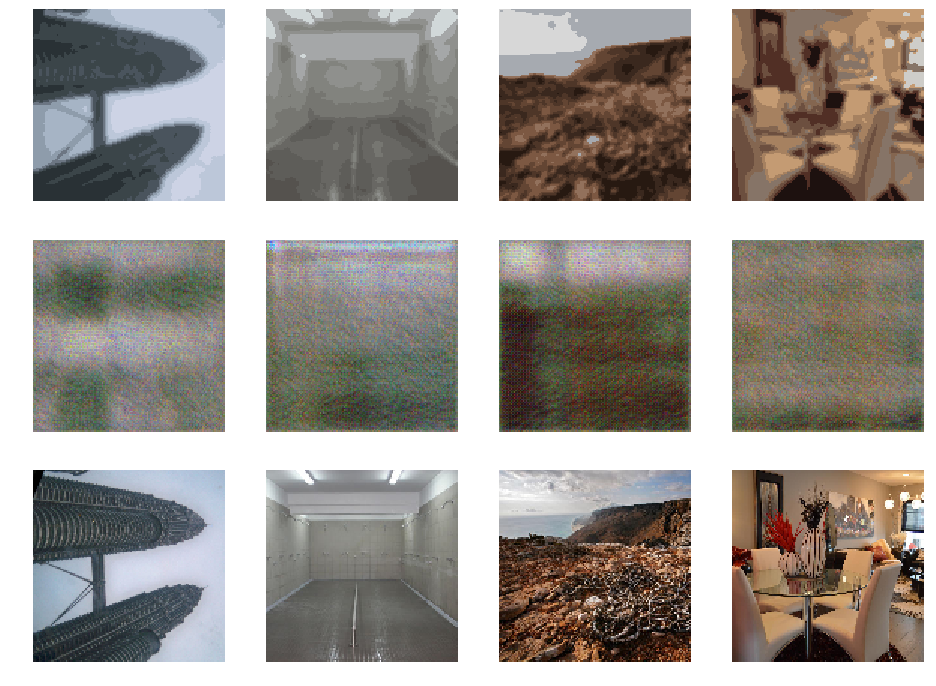

0           100                        0.697725    0.424994        0.417172      0.697725    
     total [##################################################] 100.00%
this epoch [#########.........................................] 18.42%
       100 iter, 0 epoch / 100 iterations
  0.035978 iters/sec. Estimated time to finish: 0:00:00.


In [0]:
trainer.run()

In [0]:
chainer.serializers.save_npz(OUT+'mane_de.npz', gen.decoder)
chainer.serializers.save_npz(OUT+'mane_dis_gen.npz', dis_gen)
chainer.serializers.save_npz(OUT+'mane_opt_de.npz', opt_de)
chainer.serializers.save_npz(OUT+'mane_opt_dis_gen.npz', opt_dis_gen)
chainer.serializers.save_npz(OUT+'mane_en.npz', gen.encoder)
chainer.serializers.save_npz(OUT+'mane_opt_en.npz', opt_en)
    
if phase >= 2:
    chainer.serializers.save_npz(OUT+'mane_dis_en.npz', dis_en)
    chainer.serializers.save_npz(OUT+'mane_opt_dis_en.npz', opt_dis_en)